In [1]:

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# ─── Hyperparameters ───────────────────────────────────────────────────────────
batch_size      = 64
test_batch_size = 1000
epochs          = 15
lr              = 0.01
momentum        = 0.9
log_interval    = 100
device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ─── Data transforms & loaders ─────────────────────────────────────────────────
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = DataLoader(
    datasets.MNIST(root='./data', train=True,  download=True,  transform=transform),
    batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    datasets.MNIST(root='./data', train=False, download=True,  transform=transform),
    batch_size=test_batch_size, shuffle=False
)


100%|██████████| 9.91M/9.91M [00:41<00:00, 237kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 94.5kB/s]
100%|██████████| 1.65M/1.65M [00:07<00:00, 213kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.44MB/s]


In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model     = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [4]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# ─── Training Loop ────────────────────────────────────────────────────────────
def train(epoch):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader, 1):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)

        if batch_idx % log_interval == 0:
            print(f'Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] Loss: {loss.item():.4f}')

    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)

In [5]:
def validate():
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    accuracy = 100. * correct / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(accuracy)
    print(f'\nValidation — Avg loss: {avg_val_loss:.4f}, Accuracy: {correct}/{len(val_loader.dataset)} ({accuracy:.2f}%)\n')

Epoch 1 [6400/60000] Loss: 0.7271
Epoch 1 [12800/60000] Loss: 0.2286
Epoch 1 [19200/60000] Loss: 0.1412
Epoch 1 [25600/60000] Loss: 0.1105
Epoch 1 [32000/60000] Loss: 0.1535
Epoch 1 [38400/60000] Loss: 0.1604
Epoch 1 [44800/60000] Loss: 0.1265
Epoch 1 [51200/60000] Loss: 0.1922
Epoch 1 [57600/60000] Loss: 0.0824

Validation — Avg loss: 0.0637, Accuracy: 9795/10000 (97.95%)

Epoch 2 [6400/60000] Loss: 0.2141
Epoch 2 [12800/60000] Loss: 0.0275
Epoch 2 [19200/60000] Loss: 0.1052
Epoch 2 [25600/60000] Loss: 0.2108
Epoch 2 [32000/60000] Loss: 0.0332
Epoch 2 [38400/60000] Loss: 0.0822
Epoch 2 [44800/60000] Loss: 0.0997
Epoch 2 [51200/60000] Loss: 0.0815
Epoch 2 [57600/60000] Loss: 0.0384

Validation — Avg loss: 0.0452, Accuracy: 9862/10000 (98.62%)

Epoch 3 [6400/60000] Loss: 0.0457
Epoch 3 [12800/60000] Loss: 0.0320
Epoch 3 [19200/60000] Loss: 0.1276
Epoch 3 [25600/60000] Loss: 0.0252
Epoch 3 [32000/60000] Loss: 0.0557
Epoch 3 [38400/60000] Loss: 0.1300
Epoch 3 [44800/60000] Loss: 0.1041
Ep

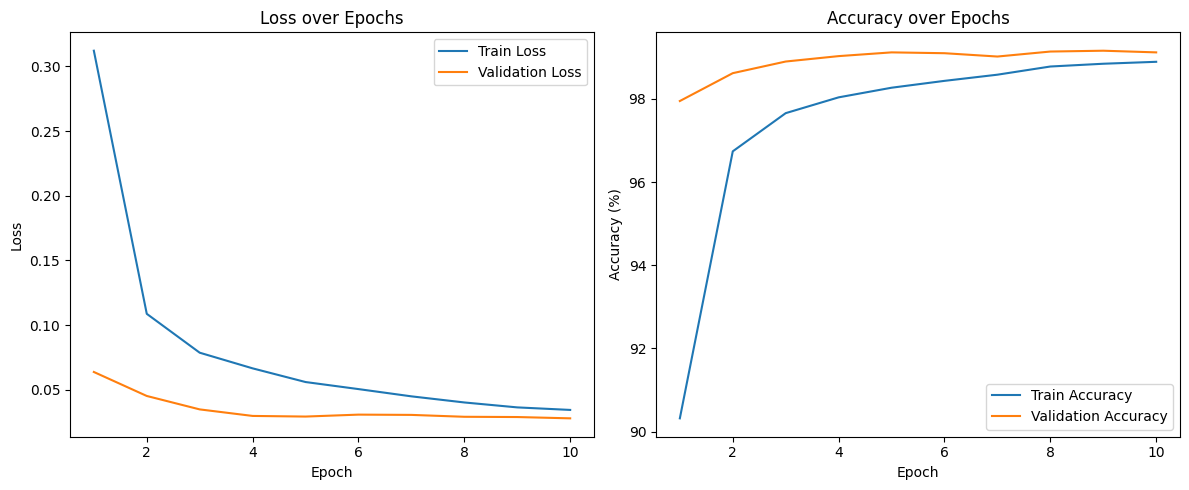

In [6]:
if __name__ == '__main__':
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        train(epoch)
        validate()

    elapsed = time.time() - start_time
    mins, secs = divmod(elapsed, 60)
    print(f'Total training+validation time: {mins:.0f}m {secs:.2f}s ({elapsed:.2f}s)')

    # ─── Final Report ──────────────────────────────────────────────────────────
    print("\nFinal Training Accuracy: {:.2f}%".format(train_accuracies[-1]))
    print("Final Validation Accuracy: {:.2f}%".format(val_accuracies[-1]))
    print("Final Training Loss: {:.4f}".format(train_losses[-1]))
    print("Final Validation Loss: {:.4f}".format(val_losses[-1]))

    # ─── Plot Results ─────────────────────────────────────────────────────────
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
